# init

In [1]:
import pandas  as pd
import pickle
import matplotlib.pyplot
import sys
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
import matplotlib.pyplot as plt
from functools import reduce
from tqdm import tqdm
import  snakeviz
import seaborn as sns


import itertools

In [2]:
sys.path.append('C:\Repos\WhoCell\who_cell')
sys.path.append('C:\Repos\WhoCell')
sys.path.append('C:\Repos\WhoCell\who_cell\experiments')
sys.path.append('C:/Repos/WhoCell/who_cell/models')
sys.path.append('C:\Repos\pomegranate')

from pomegranate import *
import transitions_dict
import who_cell
from gibbs_experiments import GibbsExperiment
from gibbs_sampler import GibbsSampler

In [3]:
%load_ext snakeviz

# code and run

In [6]:
 params_dict = {
            'N' : [12],
            'd' : [8],
            'n_states' : [20],
            'number_of_smapled_traj' : [5],
            'p_prob_of_observation' : [0.7,1],
            'N_itres': [20,21],
            'w_smapler_n_iter': [10]}
    
all_results = GibbsExperiment.run_multi_params_and_return_results(params_dict)

 48%|███████████████████████████████████████                                           | 10/21 [00:00<00:00, 16.34it/s]C:\Repos\WhoCell\who_cell\models\gibbs_sampler.py:255: RuntimeWarning: invalid value encountered in double_scalars
  _res = emmisions[((state_ind, time_ind), time_ind)] / _sum
100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 14.16it/s]


In [7]:
def is_transition_exist(_from,_to,trans) : 
    if _from in trans.keys() :
        return _to in trans[_from].keys() 
    return False

def build_pome_model_from_collections(_mues,_trans,_params) :
    _params = {k:v for k,v in _params}
    states_track = {}
    _model = HiddenMarkovModel("test")
    for _d,_t in itertools.product(list(range(_params['d'])),
                                   list(range(_params['N']))) : 
        mu = _mues[_d,_t]
        _dist = NormalDistribution(mu, mu/10)
        _state = State(_dist, name=f"({_d},{_t})")
        _model.add_state(_state)
        states_track[f"({_d},{_t})"]=_state

    _model.add_state(_model.start)
    _model.add_state(_model.end)

    for _d,_t in itertools.product(list(range(_params['d'])),
                                   list(range(_params['N']))) :
        for _dd,_tt in itertools.product(list(range(_params['d'])),
                                   list(range(_params['N']))) :
            if (_tt - _t) != 1 : 
                continue
            
            if is_transition_exist((_d,_t),(_dd,_tt),_trans) : 
                _from = states_track[f"({_d},{_t})"]
                _to = states_track[f"({_dd},{_tt})"]
                _weight = _trans[(_d,_t)][(_dd,_tt)]
    #             print(f"({_d},{_t})" + '==>' + f"({_dd},{_tt})")
                _model.add_transition(_from,_to,_weight)


    for _d,_t in itertools.product(list(range(_params['d'])),
                                   list(range(_params['N']))) :

        if _t == 0 :
            _model.add_transition(_model.start,states_track[f"({_d},{_t})"],1)
        if _t == _params['N']-1 : 
            _model.add_transition(states_track[f"({_d},{_t})"],_model.end,1)

    _model.bake(merge = None)
    
    return _model

In [8]:
def extrect_states_transitions_dict_from_pome_model(model,states = None) : 
    if states is None : 
        states = model.get_params()['states']
    
    edges = model.get_params()['edges']
    transition_dict = {}
    final_states = [] 
    for e in edges : 
        if ('start' in  states[e[0]].name)   :
            continue
        if ('end' in  states[e[1]].name) : 
            final_states.append(eval(states[e[0]].name))
            continue

        _from = eval(states[e[0]].name)
        _to = eval(states[e[1]].name)
        _weight = e[2]

        if _from not in transition_dict.keys() : 
            transition_dict[_from] = {_to : _weight}
        else : 
            transition_dict[_from][_to] = _weight
    return transition_dict, final_states 

def build_states_from_mues_matrix(mues,N,d) : 
    print("warning : this code assumes std = 1/10")
    states = {}
    for _d,_t in itertools.product(list(range(d)),list(range(N))) : 
        mu = mues[_d,_t]
        dist = NormalDistribution(mu, 1/10)
        _state = State(_dist, name=f"({_d},{_t})")
        states[(_d,_t)] = _state
    return states
            
def calculate_prob_of_sample(model,samples,param):
    _params = {k:v for k,v in param}
    if type(model) is HiddenMarkovModel : 
        states = model.get_params()['states']
        transition_dict, final_states = extrect_states_transitions_dict_from_pome_model(model,states)
        
        _states_dict = {eval(s.name):s for s in states if not (('start' in s.name) or ('end' in s.name))}
        _states = list(transition_dict.keys()) + final_states
    
    else :
        print('hello')
        transition_dict = model[1] 
        states = build_states_from_mues_matrix(model[0],_params['N'],_params['d'])
    
    gs = GibbsSampler(_params['N'],_params['d'])    
    start_prob = gs._build_start_prob(transition_dict,_params['N'],_params['d'])
    results = []
    for sample in samples : 
        emm = gs._build_emmisions_for_sample(sample,list(range(_params['N'])),_states_dict,_params['d'],_params['N'],normalized_emm = False)
        prior = gs._fwd_bkw(_states, start_prob, transition_dict, emm, _params['N'],_params['d'], only_forward = True)
        res =  sum([sum(time_prior.values()) for time_prior in prior])
        results.append(res)
    return results

def kl_distances_over_original(original_model,sampled_models,params):
    samples_for_comperison = original_model.sample(1000)
    _org_prob = calculate_prob_of_sample(original_model,samples_for_comperison,params)
    
    results = [] 
    for _model_for_compr in sampled_models:
        _comp_prob = calculate_prob_of_sample(_model_for_compr,samples_for_comperison,params)
        _org_prob_log = np.log(_org_prob)
        _comp_prob_log = np.log(_comp_prob)
        
        kl_distnace = sum((_org_prob_log - _comp_prob_log)*_org_prob)/(len(samples_for_comperison)*len(samples_for_comperison[0]))
        results.append(kl_distnace)
    return results

In [9]:
def calculate_measure_over_all_permuts(all_results):
    measure_results = {} 
    with tqdm(total=len(all_results.keys())) as pbar:
        for single_permut in all_results.values() : 
            original_model = single_permut['original_pome_model']
            sampled_models = [build_pome_model_from_collections(mues,trans,single_permut['params']) for mues,trans in zip(single_permut['all_mues'],single_permut['all_transitions'])]
            params = single_permut['params']
            measures_over_iters = kl_distances_over_original(original_model,sampled_models,params)
            
            exp_name = reduce(lambda x,y:str(x)+str(y),params)
            measure_results[exp_name] = measures_over_iters
            pbar.update(1)
    return measure_results

measure_results = calculate_measure_over_all_permuts(all_results)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:02<00:00, 60.52s/it]


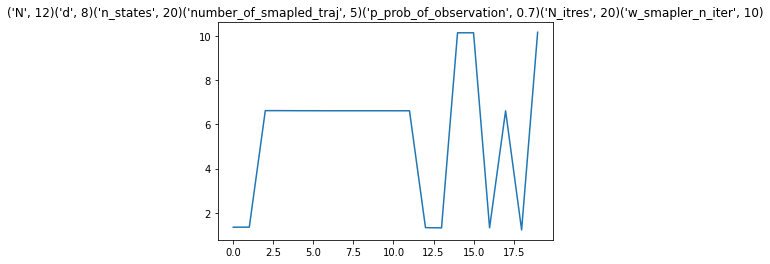

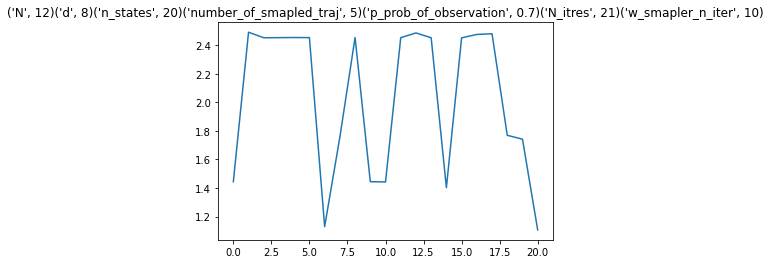

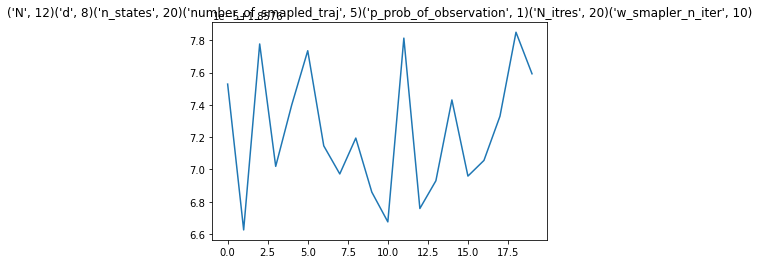

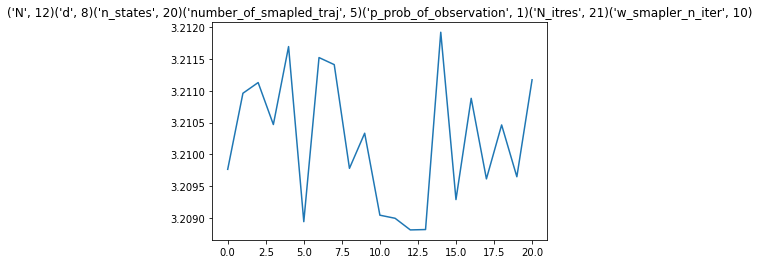

In [10]:
for exp_name,results_list in measure_results.items() : 
    sns.lineplot(list(range(len(results_list))),results_list)
    plt.title(exp_name)
    plt.show()

In [11]:
def calculate_insertion_error_over_all_permuts(all_results) : 
    counts_per_permut = {}
    for single_permut in all_results.values() : 
        transitions_all_iters = single_permut["all_transitions"] 
        original_model = single_permut["original_pome_model"]
        params = single_permut['params']
        exp_name = reduce(lambda x,y:str(x)+str(y),params)
        
        insertion_error_for_iter = []
        for _iter in range(len(transitions_all_iters)) : 
            sampled_res = transitions_all_iters[_iter]
            real_res = extrect_states_transitions_dict_from_pome_model(original_model)[0]
            res = []
            for _d,_n in itertools.product(range(params[1][1]),range(params[0][1])) : 
                for _dd,_nn in itertools.product(range(params[1][1]),range(params[0][1])) : 
                    _from = (_d,_n)
                    _to = (_dd,_nn)

                    if _from in sampled_res.keys() :
                        if _to in sampled_res[_from].keys() :
                            _val = sampled_res[_from][_to]
                        else :
                            _val = 0 
                    else : 
                        _val = 0

                    if _from in real_res.keys() :
                        if _to in real_res[_from].keys() :
                            _val_real = real_res[_from][_to]
                        else :
                            _val_real = 0 
                    else : 
                        _val_real = 0

                    res.append([_from,_to,_val,_val_real])

            final_df_for_iter = pd.DataFrame(columns=['from','to',"sampled",'real'],data = res)
            _insertion_error_for_iter = sum(((final_df_for_iter["sampled"] != 0) & (final_df_for_iter["real"]==0)))
            insertion_error_for_iter.append(_insertion_error_for_iter)
        counts_per_permut[exp_name] = insertion_error_for_iter
    return counts_per_permut
            


In [12]:
insertion_error_per_permut = calculate_insertion_error_over_all_permuts(all_results)

0 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 5)('p_prob_of_observation', 0.7)('N_itres', 20)('w_smapler_n_iter', 10)
1 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 5)('p_prob_of_observation', 0.7)('N_itres', 21)('w_smapler_n_iter', 10)
2 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 5)('p_prob_of_observation', 1)('N_itres', 20)('w_smapler_n_iter', 10)
3 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 5)('p_prob_of_observation', 1)('N_itres', 21)('w_smapler_n_iter', 10)


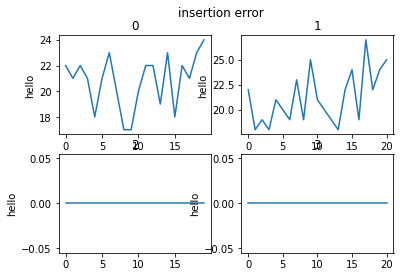

In [17]:
_dim = int(np.ceil(np.sqrt(len(insertion_error_per_permut.items()))))
fig,subs = plt.subplots(_dim,_dim)
fig.suptitle("insertion error")
exp_idx = 0
for (exp_name,results_list),sub in zip(insertion_error_per_permut.items(),itertools.chain(*subs)) : 
    sns.lineplot(list(range(len(results_list))),results_list,ax = sub)
    sub.set_title(exp_idx)
    sub.set_ylabel('hello')
    print(f"{exp_idx} : {exp_name}")
    exp_idx += 1


[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

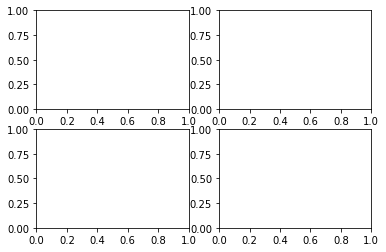

In [14]:
_,test = plt.subplots(_dim,_dim)
list(itertools.chain(*test))

# compare pome to my

In [15]:
permut_res = {} 
with tqdm(total=len(all_results.keys())) as pbar:
    for single_permut in all_results.values() : 
        original_model = single_permut['original_pome_model']
        sampled_models = [build_pome_model_from_collections(mues,trans,single_permut['params']) for mues,trans in zip(single_permut['all_mues'],single_permut['all_transitions'])]
        params = single_permut['params']
        measures_over_iters = kl_distances_over_original(original_model,sampled_models,params)
        exp_name = reduce(lambda x,y:str(x)+str(y),params)
        pbar.update(1)
        
        permut_res[exp_name] = {'original_model':original_model,
                               'sampled_models':sampled_models,
                               'params':params,
                               'measures_over_iters':measures_over_iters}
        print(exp_name)

 25%|█████████████████████                                                               | 1/4 [00:45<02:16, 45.34s/it]

('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 5)('p_prob_of_observation', 0.7)('N_itres', 20)('w_smapler_n_iter', 10)


 50%|██████████████████████████████████████████                                          | 2/4 [01:33<01:32, 46.10s/it]

('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 5)('p_prob_of_observation', 0.7)('N_itres', 21)('w_smapler_n_iter', 10)


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:26<00:48, 48.35s/it]

('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 5)('p_prob_of_observation', 1)('N_itres', 20)('w_smapler_n_iter', 10)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:19<00:00, 49.87s/it]

('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 5)('p_prob_of_observation', 1)('N_itres', 21)('w_smapler_n_iter', 10)


In [16]:
def kl_distance_between_pome_and_my(model_pome,model_self) :
    samples_for_comperison = model_pome.sample(1000)

    first_model_prob = calculate_prob_of_sample(model_self,samples_for_comperison,single_permut['params'])
    first_model_prob_log = np.log(first_model_prob)

    second_model_prob_log = [model_pome.log_probability(_sample) for _sample in samples_for_comperison]

    return sum((second_model_prob_log - first_model_prob_log)*second_model_prob_log)/(len(samples_for_comperison)*len(samples_for_comperison[0]))

count = 0
print("self")
self_distances = []
for exp_res in permut_res.values() :
    self_distances.append(kl_distance_between_pome_and_my(exp_res['original_model'],exp_res['original_model']))
    for _model in exp_res['sampled_models'] : 
        if np.random.rand() > 0.1 :
            continue
        self_distances.append(kl_distance_between_pome_and_my(_model,_model))
        count += 1
print(count)
print("near")
near_distances = [] 
for exp_res in permut_res.values() :
    for _model in exp_res['sampled_models'] : 
        if np.random.rand() > 0.1 :
            continue
        near_distances.append(kl_distance_between_pome_and_my(exp_res['original_model'],_model))
        count += 1
print(count)
print('long')
long_distance = []
for i,j in list(itertools.product(permut_res.keys(),permut_res.keys())) :
    if i == j :
        continue
    
    i_sampled = permut_res[i]['sampled_models']
    j_sampled = permut_res[j]['sampled_models']
    
    for i_model,j_model in list(itertools.product(i_sampled,j_sampled)) :
        if np.random.rand() > 0.003 :
            continue
        long_distance.append(kl_distance_between_pome_and_my(i_model,j_model))
        count += 1
print(count)       

self


KeyboardInterrupt: 

In [ ]:
for exp_res in permut_res.values() :
    print(kl_distance_between_pome_and_my(exp_res['original_model'],exp_res['original_model']))
    for _model in exp_res['sampled_models'] : 
        if np.random.rand() > 0.1 :
            continue
        print(kl_distance_between_pome_and_my(_model,_model))

In [ ]:
plt.hist(self_distances)


In [ ]:
plt.hist(self_distances)
plt.hist(near_distances)
plt.hist(long_distance)
plt.legend()

In [ ]:
plt.hist(self_distances)
plt.hist(near_distances)
plt.hist(long_distance)
plt.legend()

In [ ]:
import scipy

In [ ]:
def calculate_prob_of_sample(model,samples,param):
    _params = {k:v for k,v in param}
    if type(model) is HiddenMarkovModel : 
        states = model.get_params()['states']
        transition_dict, final_states = extrect_states_transitions_dict_from_pome_model(model,states)
        
        _states_dict = {eval(s.name):s for s in states if not (('start' in s.name) or ('end' in s.name))}
        _states = list(transition_dict.keys()) + final_states
    
    else :
        print('hello')
        transition_dict = model[1] 
        states = build_states_from_mues_matrix(model[0],_params['N'],_params['d'])
    
    gs = GibbsSampler(_params['N'],_params['d'])    
    start_prob = gs._build_start_prob(transition_dict,_params['N'],_params['d'])
    results = []
    for sample in samples : 
        emm = gs._build_emmisions_for_sample(sample,list(range(_params['N'])),_states_dict,_params['d'],_params['N'],normalized_emm = False)
        prior = gs._fwd_bkw(_states, start_prob, transition_dict, emm, _params['N'],_params['d'], only_forward = True)
        res =  sum(prior[-1].values())
        results.append(res)
    return results




samples = i_model.sample(100)
first_results = calculate_prob_of_sample(i_model,samples,single_permut['params'])
second_results = [i_model.log_probability(sa) for sa in samples]


print(scipy.stats.spearmanr(np.log(first_results),second_results))
list(zip(np.log(first_results),second_results))


In [ ]:
_params = single_permut['params']
_params = {k:v for k,v in _params}

sample = i_model.sample()

states = i_model.get_params()['states']
transition_dict, final_states = extrect_states_transitions_dict_from_pome_model(i_model,states)

_states_dict = {eval(s.name):s for s in states if not (('start' in s.name) or ('end' in s.name))}
_states = list(transition_dict.keys()) + final_states

gs = GibbsSampler(_params['N'],_params['d'])    
start_prob = gs._build_start_prob(transition_dict,_params['N'],_params['d'])
emm = gs._build_emmisions_for_sample(sample,list(range(_params['N'])),_states_dict,_params['d'],_params['N'],normalized_emm = False)
prior = gs._fwd_bkw(_states, start_prob, transition_dict, emm, _params['N'],_params['d'], only_forward = True)

prior_pome= np.exp(i_model.forward(sample))

In [ ]:
prior[0]

In [ ]:
for time in prior_pome : 
    print(time)

# run from pomegranate

C:\Repos\WhoCell\who_cell\models\gibbs_sampler.py:255: RuntimeWarning: invalid value encountered in double_scalars
  _res = emmisions[((state_ind, time_ind), time_ind)] / _sum
  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

different models


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [53:57<00:00, 809.50s/it]


0 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 50)('p_prob_of_observation', 0.7)('N_itres', 100)('w_smapler_n_iter', 10)
1 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 50)('p_prob_of_observation', 1)('N_itres', 100)('w_smapler_n_iter', 10)
2 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 300)('p_prob_of_observation', 0.7)('N_itres', 100)('w_smapler_n_iter', 10)
3 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 300)('p_prob_of_observation', 1)('N_itres', 100)('w_smapler_n_iter', 10)


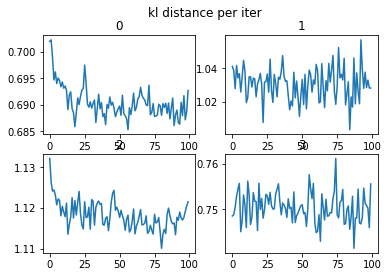

0 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 50)('p_prob_of_observation', 0.7)('N_itres', 100)('w_smapler_n_iter', 10)
1 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 50)('p_prob_of_observation', 1)('N_itres', 100)('w_smapler_n_iter', 10)
2 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 300)('p_prob_of_observation', 0.7)('N_itres', 100)('w_smapler_n_iter', 10)
3 : ('N', 12)('d', 8)('n_states', 20)('number_of_smapled_traj', 300)('p_prob_of_observation', 1)('N_itres', 100)('w_smapler_n_iter', 10)


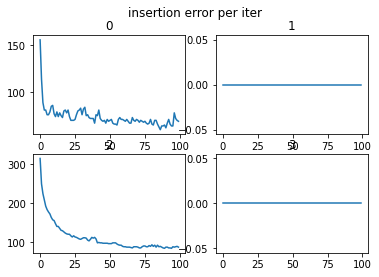

mutual models
0 : ('number_of_smapled_traj', 50)('p_prob_of_observation', 0.7)('N', 12)('d', 8)('n_states', 20)('N_itres', 100)('w_smapler_n_iter', 15)
1 : ('number_of_smapled_traj', 50)('p_prob_of_observation', 1)('N', 12)('d', 8)('n_states', 20)('N_itres', 100)('w_smapler_n_iter', 15)
2 : ('number_of_smapled_traj', 100)('p_prob_of_observation', 0.7)('N', 12)('d', 8)('n_states', 20)('N_itres', 100)('w_smapler_n_iter', 15)
3 : ('number_of_smapled_traj', 100)('p_prob_of_observation', 1)('N', 12)('d', 8)('n_states', 20)('N_itres', 100)('w_smapler_n_iter', 15)


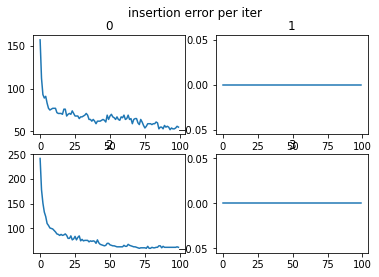

In [5]:
params_dict = {
        'N': [12],
        'd': [8],
        'n_states': [20],
        'number_of_smapled_traj': [50,300],
        'p_prob_of_observation': [0.7, 1],
        'N_itres': [100],
        'w_smapler_n_iter': [10]}

mutual_model_params_dict ={
    'N': 12,
    'd': 8,
    'n_states': 20,
    'N_itres': 100,
    'w_smapler_n_iter': 15}

hyper_params_dict = {
    'number_of_smapled_traj': [50,100],
    'p_prob_of_observation': [0.7, 1]}

params_titles = {
    "insertion_error" :
    {'x':'iteration',
    'y':'insertion_error',
    "title" : "insertion error different models "},
    "kl_distance" :
    {'x':'iteration',
    'y':'kl distance',
    "title" : "kl distance to original, different models "}
}

mutual_model_params_titles = {
    "insertion_error" :
    {'x':'iteration',
    'y':'insertion_error',
    "title" : "insertion error same model "},
    "kl_distance" :
    {'x':'iteration',
    'y':'kl distance',
    "title" : "kl distance to original, same models "}
}


GibbsExperiment.run_multi_params_and_plot_report(params_dict,mutual_model_params_dict,hyper_params_dict,params_titles,mutual_model_params_titles)